In [1]:
import os
import re
import sys
import glob
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
from Bio import pairwise2, SeqRecord, Seq
from Bio.Data import CodonTable

import pymutspec
from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id, CodonAnnotation
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.io import GenesStates

### Mammals

In [2]:
ref = next(SeqIO.parse("../data/mammals/raw/outgrp.gb", format="gb"))
ref.description

'Cociella crocodila voucher HABs-2016-007 mitochondrion, complete genome'

In [46]:
for f in ref.features:
    if f.type == "CDS":
        if f.qualifiers["gene"] == ['CYTB']:
            cytb = str(f.extract(ref.seq))
        if f.qualifiers["gene"] == ['ND1']:
            nd1 = str(f.extract(ref.seq))

In [47]:
print(cytb)
print(nd1)

ATGGCCAACTTACGAAAAACCCACCCCTTACTCAAAATTGCTAACAATGCTTTAGTAGACCTCCCCGCCCCCTCCAACATCTCCGCATGATGAAACTTTGGGTCCCTTTTAGGACTATGCTTAATTATCCAAATCCTCTCAGGCTTATTTCTAGCTATACATTACACATCAGATGTCGCTACAGCCTTCTCCTCCGTTGCCCACATCTGCCGAGACGTAAATTACGGCTGGCTAATTCGCAATCTCCACGCAAACGGAGCATCATTCTTTTTTATCTGCATTTATATACACATCGGACGCGGCCTCTACTACGGATCATACCTTTTTAAAGAGACATGAAACATTGGCGTCGTGCTCTTGCTCCTCGTAATAGTCACCGCTTTCGTGGGCTACGTCCTCCCCTGAGGACAAATATCATTCTGAGGCGCCACGGTTATTACCAACCTTCTGTCCGCCGTCCCTTATATTGGTAACACCCTCGTTCAATGAATCTGAGGAGGCTTCTCAGTAGATAATGCTACATTAAACCGTTTCTTCGCGTTCCATTTCCTTTTCCCGTTCATCATCGCAGCCGCCACTATAATCCACCTTCTATTCCTTCACCAAACTGGTTCTAACAACCCGCTTGGGCTATGGCTCAACACAGACAAAATTTCCTTCCACCCCTACTTCTCATATAAAGACCTCTTAGGGTTCGCAGGCCTTCTACTGACCTTAACAGCTTTAGCACTTTTTTCTCCCAACCTCTTAGGAGATCCTGATAACTTCACCCCGGCCAACCCCCTCGTAACCCCTCCCCATATTAAACCAGAATGATACTTCTTATTTGCATACGCTATTCTCCGCTCAATCCCTAATAAACTAGGAGGCGTACTAGCCCTCCTAGCCTCAATCTTAATTCTCATACTAATCCCGATTCTTCACACATCAAAACAACGAAGTTTAACATTCCGCCCTGTCTCTCAACTCCTGTTCTGGGCCCTTATTGCAGACGTCGCAA

## Prepare Data

In [48]:
ref = pymutspec.io.read_genbank_ref("../data/NC_012920.1.gb")

In [49]:
def get_gene(gname: str):
    """
    ['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3',
       'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB']
    """
    seq = "".join(ref[ref.GeneName == gname].Nuc.values)
    return seq 

In [50]:
ct = CodonTable.unambiguous_dna_by_id[2]

for g in ['ND1', 'CYTB']:
    s = Seq.Seq(get_gene(g))
    print(g)
    print(str(s.translate(2)))
    print()

ND1
MPMANLLLLIVPILIAMAFLMLTERKILGYMQLRKGPNVVGPYGLLQPFADAMKLFTKEPLKPATSTITLYITAPTLALTIALLLWTPLPMPNPLVNLNLGLLFILATSSLAVYSILWSGWASNSNYALIGALRAVAQTISYEVTLAIILLSTLLMSGSFNLSTLITTQEHLWLLLPSWPLAMMWFISTLAETNRTPFDLAEGESELVSGFNIEYAAGPFALFFMAEYTNIIMMNTLTTTIFLGTTYDALSPELYTTYFVTKTLLLTSLFLWIRTAYPRFRYDQLMHLLWKNFLPLTLALLMWYVSMPITISSIPPQT

CYTB
MTPMRKTNPLMKLINHSFIDLPTPSNISAWWNFGSLLGACLILQITTGLFLAMHYSPDASTAFSSIAHITRDVNYGWIIRYLHANGASMFFICLFLHIGRGLYYGSFLYSETWNIGIILLLATMATAFMGYVLPWGQMSFWGATVITNLLSAIPYIGTDLVQWIWGGYSVDSPTLTRFFTFHFILPFIIAALATLHLLFLHETGSNNPLGITSHSDKITFHPYYTIKDALGLLLFLLSLMTLTLFSPDLLGDPDNYTLANPLNTPPHIKPEWYFLFAYTILRSVPNKLGGVLALLLSILILAMIPILHMSKQQSMMFRPLSQSLYWLLAADLLILTWIGGQPVSYPFTIIGQVASVLYFTTILILMPTISLIENKMLKWA



### Extract genes from alignment of genomes

In [51]:
genomes = []
genes = {}
for rec in SeqIO.parse("../data/GAGP/Mitochondria_GreatApes.muscle2.fasta2line", format="fasta"):
    if rec.id in ['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB']:
        genes[rec.id] = str(rec.seq)
    else:
        genomes.append(rec)

In [52]:
genes_pos = {}
for g, seq in genes.items():
    m = re.match("(-+)(\w+)(-+)", seq)
    n = len(seq)
    if sum([len(x) for x in m.groups()]) == n:
        gaps_up, _, gaps_down = m.groups()
        p1 = len(gaps_up)
        p2 = n - len(gaps_down)
        genes_pos[g] = tuple((p1, p2))
    else:
        print("errror")
        break

In [53]:
genes_pos

{'ND6': (13620, 14145),
 'COX3': (8677, 9461),
 'ND3': (9529, 9875),
 'ND4L': (9940, 10230),
 'ATP6': (7997, 8677),
 'ND5': (11808, 13620),
 'ATP8': (7836, 7997),
 'COX2': (7038, 7722),
 'COX1': (5355, 6897),
 'ND1': (2741, 3697),
 'ND2': (3904, 4946),
 'ND4': (10230, 11608),
 'CYTB': (14218, 15359)}

In [54]:
new_records = []
for gene, (p1, p2) in genes_pos.items():
    grec = []
    for genome in genomes:
        seq = genome.seq[p1: p2]
        idx = genome.id + "_" + gene
        r = SeqRecord.SeqRecord(seq, idx, idx, idx)
        new_records.append(r)
        grec.append(r)

    with open(f"../data/GAGP/genes/{gene}.fna", "w") as handle:
        SeqIO.write(grec, handle, "fasta-2line")

# with open("../data/GAGP/genes.fna", "w") as handle:
#     SeqIO.write(new_records, handle, "fasta-2line")

## Site rates categories

### HUMAN

In [2]:
path_to_hrates = "../data/GAGP/human_rates/"
data = []
for p in glob.glob(path_to_hrates + "*.rate"):
    d = pd.read_csv(p, sep="\t", comment="#")
    d["Gene"] = os.path.basename(p).replace(".rate", "")
    data.append(d)
hrates = pd.concat(data)

In [3]:
hrates_cats = hrates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
hrates_cats

Cat,0,1,2,3,4,5,6
Gene,,,,,,,
ATP6,425,11,39,12,35,46,110
ATP8,90,3,9,3,3,23,28
COX1,1129,7,58,82,72,68,126
COX2,506,26,31,12,11,25,73
COX3,567,101,7,0,2,1,105
CYTB,788,37,70,24,63,33,125
ND1,670,28,25,40,56,44,91
ND2,699,78,39,3,17,3,202
ND3,231,7,16,15,20,12,44


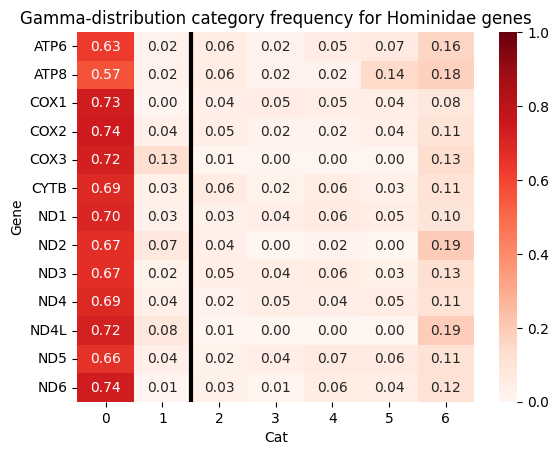

In [4]:
plt.title("Gamma-distribution category frequency for Hominidae genes")
sns.heatmap((hrates_cats.T / hrates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_human.pdf", bbox_inches="tight")
plt.show()

### MUS

In [5]:
path_to_hrates = "../data/MUS/mus_rates/"
data = []
for p in glob.glob(path_to_hrates + "*.rate"):
    d = pd.read_csv(p, sep="\t", comment="#")
    d["Gene"] = os.path.basename(p).replace(".rate", "")
    data.append(d)
mrates = pd.concat(data)

In [6]:
mrates_cats = mrates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
mrates_cats

Cat,0,1,2,3,4,5,6
Gene,,,,,,,
CYTB,565,74,67,79,120,133,63
ND1,581,36,65,76,51,75,73


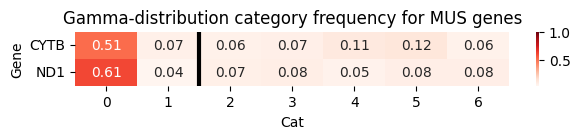

In [7]:
plt.figure(figsize=(7, 0.7))
plt.title("Gamma-distribution category frequency for MUS genes")
sns.heatmap((mrates_cats.T / mrates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_mus.pdf", dpi=300,bbox_inches="tight")
plt.show()

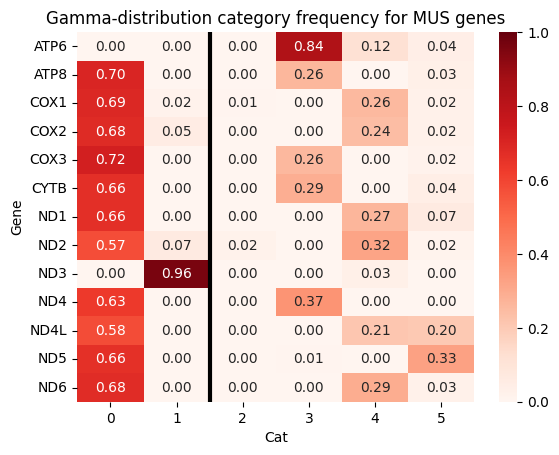

In [36]:
plt.title("Gamma-distribution category frequency for MUS genes")
sns.heatmap((mrates_cats.T / mrates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_mus.pdf", dpi=300,bbox_inches="tight")
plt.show()

### Mammals

In [27]:
data = []
d = pd.read_csv("../data/exposure/mammals_nd1/iqtree.rate", sep="\t", comment="#")
d["Gene"] = "ND1"
data.append(d)
d = pd.read_csv("../data/exposure/mammals_cytb/iqtree.rate", sep="\t", comment="#")
d["Gene"] = "CYTB"
data.append(d)
mam_rates = pd.concat(data)

In [28]:
mam_rates_cats = mam_rates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
mam_rates_cats

Cat,0,1,2,3,4,5
Gene,,,,,,
CYTB,499,106,81,121,207,126
ND1,402,85,84,110,150,123


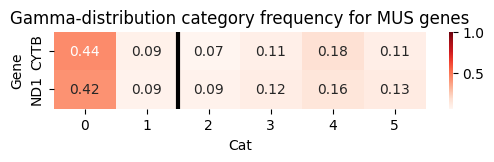

In [29]:
plt.figure(figsize=(6, 1))
plt.title("Gamma-distribution category frequency for Mammals genes")
sns.heatmap((mam_rates_cats.T / mam_rates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_mammals.pdf", bbox_inches="tight")
plt.show()

## Expected mutations excluding invariant positions

In [8]:
coda = CodonAnnotation(2)

In [9]:
human_cytb = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_cytb/alignment_checked.fasta", format="fasta")]
human_nd1 = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_nd1/alignment_checked.fasta", format="fasta")]
human_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/human_cytb/CYTB.rate"))[1]
human_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/human_nd1/ND1.rate"))[1]

mus_cytb = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_cytb/alignment_checked.fasta", format="fasta")]
mus_nd1 = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_nd1/alignment_checked.fasta", format="fasta")]
mus_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mus_cytb/CYTB.rate"))[1]
mus_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mus_nd1/ND1.rate"))[1]

mammals_cytb = [str(x.seq) for x in SeqIO.parse("../data/exposure/mammals_cytb/alignment_checked.fasta", format="fasta")]
mammals_nd1 = [str(x.seq) for x in SeqIO.parse("../data/exposure/mammals_nd1/alignment_checked.fasta", format="fasta")]
mammals_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mammals_cytb/iqtree.rate"))[1]
mammals_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mammals_nd1/iqtree.rate"))[1]

In [29]:
lbl = "syn"
full_exp_summary = []

### Human CYTB

In [30]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in human_cytb:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, human_cytb_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(human_cytb)
        exp_masked12[sbs] += em12[lbl][sbs] / len(human_cytb)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(human_cytb)
        exp_masked192[sbs] += em192[lbl][sbs] / len(human_cytb)


In [31]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[0][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,88.267362,138.276020,88.267362,88.070861,88.070861,207.935324,13.347411,6.816575,6.816575,15.124934,54.760558,15.124934
exp_masked,40.182011,59.499382,40.182011,54.116275,54.116275,119.172115,12.257819,6.757201,6.757201,15.051953,50.598339,15.051953


In [32]:
dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/human_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

### Human ND1

In [33]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in human_nd1:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, human_nd1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(human_nd1)
        exp_masked12[sbs] += em12[lbl][sbs] / len(human_nd1)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(human_nd1)
        exp_masked192[sbs] += em192[lbl][sbs] / len(human_nd1)


In [34]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[1][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,69.906921,116.663484,69.906921,91.406623,91.406623,178.230609,17.115752,9.030728,9.030728,16.204654,42.099940,16.204654
exp_masked,33.043854,49.038484,33.043854,57.590394,57.590394,101.563544,15.931086,8.966289,8.966289,15.122017,36.924821,15.122017


In [35]:
dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12.get(sbs, 0.)
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/human_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

### Mus CYTB

In [36]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mus_cytb:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mus_cytb_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mus_cytb)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mus_cytb)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mus_cytb)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mus_cytb)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mus_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

In [37]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[2][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,99.881818,153.127273,99.881818,44.336364,44.336364,145.437662,10.094805,5.801299,5.801299,18.941558,79.871429,18.941558
exp_masked,94.044156,141.323377,94.044156,44.336364,44.336364,144.519481,10.087013,5.796104,5.796104,18.929870,78.864935,18.929870


### Mus ND1

In [38]:
# import re

# from Bio import SeqIO
# import pandas as pd

# rates = pd.read_csv("data/MUS/mus_rates/ND1.rate", sep='\t', comment="#")

# non_letters_positions = set()  # 1-BASED
# for rec in SeqIO.parse("data/exposure/mus_nd1/raw_aln.fna", format="fasta"):
#     seq = str(rec.seq)
#     for i in range(0, len(seq), 3):
#         codon = seq[i: i+3]
#         if not re.match("[A-Za-z]{3}", codon):
#             non_letters_positions.add(i+1)
#             non_letters_positions.add(i+2)
#             non_letters_positions.add(i+3)

# print(sorted(non_letters_positions))

# df = rates[~rates.Site.isin(non_letters_positions)]
# df.to_csv("data/exposure/mus_nd1/ND1.rate", index=False, sep="\t")

In [39]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mus_nd1:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mus_nd1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mus_nd1)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mus_nd1)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mus_nd1)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mus_nd1)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12.get(sbs, 0.)
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mus_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

In [40]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[3][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,93.265957,162.074468,93.265957,39.946809,39.946809,113.776596,10.978723,7.765957,7.765957,21.074468,79.829787,21.074468
exp_masked,67.361702,109.085106,67.361702,39.946809,39.946809,101.510638,9.989362,6.776596,6.776596,21.063830,75.031915,21.063830


### Mammals CYTB

In [41]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mammals_cytb:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mammals_cytb_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mammals_cytb)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mammals_cytb)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mammals_cytb)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mammals_cytb)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

# exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mammals_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

In [42]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[4][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,100.181543,153.391831,100.181543,55.793495,55.793495,167.981089,13.710287,7.647504,7.647504,28.459909,83.393343,28.459909
exp_masked,100.181543,153.391831,100.181543,55.793495,55.793495,167.660363,12.711800,7.647504,7.647504,28.459909,83.272315,28.459909


### Mammals ND1

In [43]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mammals_nd1:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mammals_nd1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mammals_nd1)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mammals_nd1)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mammals_nd1)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mammals_nd1)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

# exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mammals_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

In [44]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[5][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,89.97432,147.533988,89.97432,49.350453,49.350453,127.271903,12.555891,6.604985,6.604985,25.165408,71.724320,25.165408
exp_masked,89.97281,146.519637,89.97281,49.350453,49.350453,127.057402,11.577795,6.466767,6.466767,25.165408,71.642749,25.165408


### Merge Human, Mouse and Mammals

In [45]:
a = pd.concat(full_exp_summary)
a["Species"] = np.repeat(["Human", "Mouse", "Mammals"], 4)
a["Gene"] = np.repeat(np.tile(["CYTB", "ND1"], 3), 2)

In [46]:
a.reset_index().rename(columns={"index": "Label"}).set_index(["Species", "Gene", "Label"]).round(2)

G>A     C>T    C>G    C>A     A>T     A>C     A>G  \
Species Gene Label                                                             
Human   CYTB exp         13.35  207.94  88.07  88.07   88.27   88.27  138.28   
             exp_masked  12.26  119.17  54.12  54.12   40.18   40.18   59.50   
        ND1  exp         17.12  178.23  91.41  91.41   69.91   69.91  116.66   
             exp_masked  15.93  101.56  57.59  57.59   33.04   33.04   49.04   
Mouse   CYTB exp         10.09  145.44  44.34  44.34   99.88   99.88  153.13   
             exp_masked  10.09  144.52  44.34  44.34   94.04   94.04  141.32   
        ND1  exp         10.98  113.78  39.95  39.95   93.27   93.27  162.07   
             exp_masked   9.99  101.51  39.95  39.95   67.36   67.36  109.09   
Mammals CYTB exp         13.71  167.98  55.79  55.79  100.18  100.18  153.39   
             exp_masked  12.71  167.66  55.79  55.79  100.18  100.18  153.39   
        ND1  exp         12.56  127.27  49.35  49.35   89.97   89.97  147.53   
             exp_masked  11.58  127.06  49.35  49.35   89.97   89.97  146.52   

                           T>A    T>C    T>G   G>T   G>C  
Species Gene Label                                        
Human   CYTB exp         15.12  54.76  15.12  6.82  6.82  
             exp_masked  15.05  50.60  15.05  6.76  6.76  
        ND1  exp         16.20  42.10  16.20  9.03  9.03  
             exp_masked  15.12  36.92  15.12  8.97  8.97  
Mouse   CYTB exp         18.94  79.87  18.94  5.80  5.80  
             exp_masked  18.93  78.86  18.93  5.80  5.80  
        ND1  exp         21.07  79.83  21.07  7.77  7.77  
             exp_masked  21.06  75.03  21.06  6.78  6.78  
Mammals CYTB exp         28.46  83.39  28.46  7.65  7.65  
             exp_masked  28.46  83.27  28.46  7.65  7.65  
        ND1  exp         25.17  71.72  25.17  6.60  6.60  
             exp_masked  25.17  71.64  25.17  6.47  6.47

## Intersection of invariant and synonymous positions

In [47]:
def collect_exp_muts(cds, mask=None, labels=["syn"]):
    """
    Calculate potential expected mutation counts for nucleotides and trinucleotides (context) 
    in cds gene

    Arguments
    ---------
    cds: string or iterable of strings, if len is not divisible by 3, last codon is not used in syn, syn4f and pos3 modes
        cds sequence with codon structure; 
    labels: List of label strings
        label could be one of ["all", "syn", "ff", "pos3"];
    mask:
        iterable that mask invariant positions in the cds;

    Return
    ---------
        sbs12_freqs: Dict[label, Dict[nucl, count]]
            for each label collected expected single nucleotide substitutions frequencies without contexts
        sbs192_freqs: Dict[label, Dict[context, count]]
            for each label collected expected single nucleotide substitutions frequencies with contexts
    """
    n = len(cds)
    if mask is not None and len(mask) != n:
        raise ValueError("Mask must have same lenght as cds")

    labels = set(labels)
    data = []
    for pos in range(1, n - 1):
        if mask is not None and not mask[pos]:
            continue
        pic = pos % 3
        nuc = cds[pos]
        cdn = cds[pos - pic: pos - pic + 3]
        cdn = cdn if isinstance(cdn, str) else "".join(cdn)
        cxt = cds[pos - 1: pos + 2]
        cxt = cxt if isinstance(cxt, str) else "".join(cxt)
        mut_base12 = nuc + ">" + "{}"
        mut_base192 = cxt[0] + "[" + nuc + ">{}]" + cxt[-1]

        if "syn" in labels and len(cdn) == 3:
            syn_codons = coda.get_syn_codons(cdn, pic)
            for alt_cdn in syn_codons:
                alt_nuc = alt_cdn[pic]
                data.append({
                    "Pos": pos + 1,
                    "Pic": pic + 1,
                    "Mut": mut_base192.format(alt_nuc),
                    "MutBase": mut_base12.format(alt_nuc),
                    "Cdn": cdn,
                    "Label": "syn",
                })

        for alt_nuc in coda.nucl_order:
            if alt_nuc == nuc:
                continue
            if "all" in labels:
                data.append({
                    "Pos": pos + 1,
                    "Pic": pic + 1,
                    "Mut": mut_base192.format(alt_nuc),
                    "MutBase": mut_base12.format(alt_nuc),
                    "Cdn": cdn,
                    "Label": "all",
                })
            if "pos3" in labels and pic == 2:
                data.append({
                    "Pos": pos + 1,
                    "Pic": pic + 1,
                    "Mut": mut_base192.format(alt_nuc),
                    "MutBase": mut_base12.format(alt_nuc),
                    "Cdn": cdn,
                    "Label": "pos3",
                })
            if "ff" in labels and pic == 2 and coda.is_fourfold(cdn):
                data.append({
                    "Pos": pos + 1,
                    "Pic": pic + 1,
                    "Mut": mut_base192.format(alt_nuc),
                    "MutBase": mut_base12.format(alt_nuc),
                    "Cdn": cdn,
                    "Label": "ff",
                })

    exp_sbs = pd.DataFrame(data)
    return exp_sbs

In [48]:
# for each gene in alignment get expected mutations,
# assign invariativity to each position
# and calculate how many positions are invariant

em_summary = []
for lbl, aln, mask in zip(
    ['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1', 'mammals_cytb', 'mammals_nd1'], 
    [human_cytb, human_nd1, mus_cytb, mus_nd1, mammals_cytb, mammals_nd1], 
    [human_cytb_mask, human_nd1_mask, mus_cytb_mask, mus_nd1_mask, mammals_cytb_mask, mammals_nd1_mask]
    ):
    em = []
    for seq in aln:
        em.append(collect_exp_muts(seq))
    em = pd.concat(em)
    em["Invariant"] = em.Pos.map({x:1 for x in np.where(~mask)[0] + 1}).fillna(0).astype(np.int8)
    em_summary.append({
        "Gene": lbl,
        "Syn Invariants (%)": em.Invariant.value_counts(normalize=True).to_dict()[1] * 100,
    })

In [49]:
pd.DataFrame(em_summary)

,Gene,Syn Invariants (%)
0,human_cytb,41.576651
1,human_nd1,40.470504
2,mus_cytb,3.502697
3,mus_nd1,18.074293
4,mammals_cytb,0.179438
5,mammals_nd1,0.366186


In [61]:
collect_exp_muts(seq)

,Pos,Pic,Mut,MutBase,Cdn,Label
0,3,3,T[G>A]T,G>A,ATG,syn
1,6,3,C[C>G]G,C>G,TCC,syn
2,6,3,C[C>T]G,C>T,TCC,syn
3,6,3,C[C>A]G,C>A,TCC,syn
4,9,3,C[A>T]G,A>T,GCA,syn
...,...,...,...,...,...,...
718,948,3,C[A>T]A,A>T,CCA,syn
719,948,3,C[A>C]A,A>C,CCA,syn
720,948,3,C[A>G]A,A>G,CCA,syn
721,951,3,A[A>G]T,A>G,AAA,syn
